<a href="https://colab.research.google.com/github/Vakhranev/Compling/blob/master/Vakhranyov_AY_Deep_learning_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом проекте я постарался с помощью предобученного берта сделать предсказания для текста на сентимент-анализ. Я взял датасет Sentiment Analysis Dataset.csv он есть здесь (https://github.com/vineetdhanawat/twitter-sentiment-analysis/blob/master/datasets/Sentiment%20Analysis%20Dataset.csv). Пояснений к нему, к сожалению, нет, поэтому точно сказать не могу, но, судя по всему, представленные в нём разбиты следующим образом: целевой класс (представлены единицей) — твиты с положительно-окрашенным мнением, всё остальное — представлено нулями. Помимо того, что я попробовал замерять лоссы на эпохах, также я использовал ф-меру для оценки модели.

В последнее время применение глубокого обучения для решения проблемы сентимент-анализа стало популярной темой исследований. Существуют различные архитектуры глубокого обучения и технологии, которые применяют для подобного рода анализа: эмбеддинги, автоэнкодеры, CNN, RNN, LSTM, применение аттеншн-механизма в RNN, MemNN, RecNN. Многие из этих методов глубокого обучения показали отличные результаты для различных задач сентимент-анализа. Если верить научным работам по теме, которые я просмотрел, то с развитием исследований и приложений глубокого обучения в ближайшем будущем появятся более интересные исследования применения глубокого обучения для сентимент-анализа.

In [15]:
!pip install transformers
import pandas as pd
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
data = pd.read_csv("Sentiment Analysis Dataset.csv", header= None)
max_len = 512

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
data = data[:500]
data.columns = ["id", "sentiment", "text"]

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data["id"] = label_encoder.fit_transform(data["id"])
data["sentiment"] = label_encoder.fit_transform(data["sentiment"])
data["text"] = label_encoder.fit_transform(data["text"])

In [18]:
data.head

<bound method NDFrame.head of       id  sentiment  text
0    499          2   499
1      0          0     2
2    111          0     3
3    222          1     6
4    333          0     9
..   ...        ...   ...
495  439          1   432
496  440          0   459
497  441          0   460
498  442          1   185
499  443          0   320

[500 rows x 3 columns]>

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.1, random_state=42)

In [20]:
from torch.utils.data import Dataset
class dataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):   
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(text, add_special_tokens=True,max_length=self.max_len, return_token_type_ids=False,padding='max_length', return_attention_mask=True, return_tensors='pt', truncation = True)
        return {'text': text, 'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'targets': torch.tensor(target, dtype=torch.long)}

In [21]:
import numpy as np
from torch.utils.data import DataLoader
def fn_Dataloader(data, tokenizer, max_len, batch_size):
    ds = dataset(data.text.to_numpy(), data.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)
    return DataLoader(ds,batch_size=batch_size)

batch_size = 8
loader = fn_Dataloader(train, tokenizer, max_len, batch_size)
test_loader = fn_Dataloader(test, tokenizer, max_len, batch_size)

In [22]:
print(type(loader))

torch.utils.data.dataloader.DataLoader


In [23]:
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased', return_dict=False)

In [24]:
import torch
from torch import nn
class Classifier(torch.nn.Module):
    
    def __init__(self,n_classes):
        super(Classifier, self).__init__()
        self.bert = model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [25]:
model = Classifier(3)

In [26]:
epochs = 6
for param in model.parameters():
    param.requires_grad = False
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
from tqdm import tqdm
from sklearn.metrics import f1_score
from statistics import mean
train_losses = list()
train_loss_per_epoch = list()
test_loss_per_epoch = list()
for epoch in range(epochs):
    train_epoch_losses = list()
    test_epoch_losses = list()
    train_f1s = list()
    test_f1s = list()
    print(f'Epoch: {epoch}')
    model.train()
    for element in tqdm(loader):
        x = element["input_ids"]
        mask_train = element["attention_mask"]
        y = element["targets"]
        outputs = model(input_ids=x,attention_mask=mask_train)
        _, preds = torch.max(outputs, dim=1)
        train_loss = loss(outputs, y)
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(train_loss.item())
        train_epoch_losses.append(train_loss.item())
        train_f1s.append(f1_score(y, outputs.argmax(1), average='micro'))
    model.eval()
    for element in tqdm(test_loader):
        x = element["input_ids"]
        mask_test = element["attention_mask"]
        y = element["targets"]
        with torch.no_grad():
            outputs_test = model(input_ids=x,attention_mask=mask_test)
            _, preds_test = torch.max(outputs_test, dim=1)
            test_loss = loss(outputs_test, y)
        test_epoch_losses.append(test_loss.item())        
        test_f1s.append(f1_score(y, outputs_test.argmax(1), average='micro'))
    train_loss_per_epoch.append(np.mean(train_epoch_losses))
    test_loss_per_epoch.append(np.mean(test_epoch_losses))
    mean_train = mean(train_f1s)
    mean_test = mean(test_f1s)
    print(f'Epoch {epoch}')
    print(f'Loss: train {train_loss_per_epoch[-1]:.2f} | test {test_loss_per_epoch[-1]:.2f}')
    print(f'F1: train {mean_train} | test {mean_test}')


  0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 0



100%|██████████| 57/57 [14:51<00:00, 15.65s/it]

100%|██████████| 7/7 [01:28<00:00, 12.65s/it]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 0
Loss: train 1.01 | test 1.05
F1: train 0.5153508771929824 | test 0.5714285714285714
Epoch: 1



100%|██████████| 57/57 [14:51<00:00, 15.65s/it]

100%|██████████| 7/7 [01:28<00:00, 12.69s/it]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 1
Loss: train 1.03 | test 1.04
F1: train 0.49122807017543857 | test 0.6428571428571429
Epoch: 2



100%|██████████| 57/57 [14:54<00:00, 15.69s/it]

100%|██████████| 7/7 [01:28<00:00, 12.66s/it]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 2
Loss: train 1.02 | test 1.06
F1: train 0.5 | test 0.6071428571428571
Epoch: 3



100%|██████████| 57/57 [14:51<00:00, 15.64s/it]

100%|██████████| 7/7 [01:29<00:00, 12.72s/it]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 3
Loss: train 1.03 | test 1.06
F1: train 0.5131578947368421 | test 0.625
Epoch: 4



100%|██████████| 57/57 [14:52<00:00, 15.65s/it]

100%|██████████| 7/7 [01:28<00:00, 12.64s/it]

  0%|          | 0/57 [00:00<?, ?it/s]

Epoch 4
Loss: train 1.04 | test 1.05
F1: train 0.5197368421052632 | test 0.6071428571428571
Epoch: 5



100%|██████████| 57/57 [14:53<00:00, 15.67s/it]

100%|██████████| 7/7 [01:29<00:00, 12.72s/it]

Epoch 5
Loss: train 1.01 | test 1.04
F1: train 0.5372807017543859 | test 0.6607142857142857


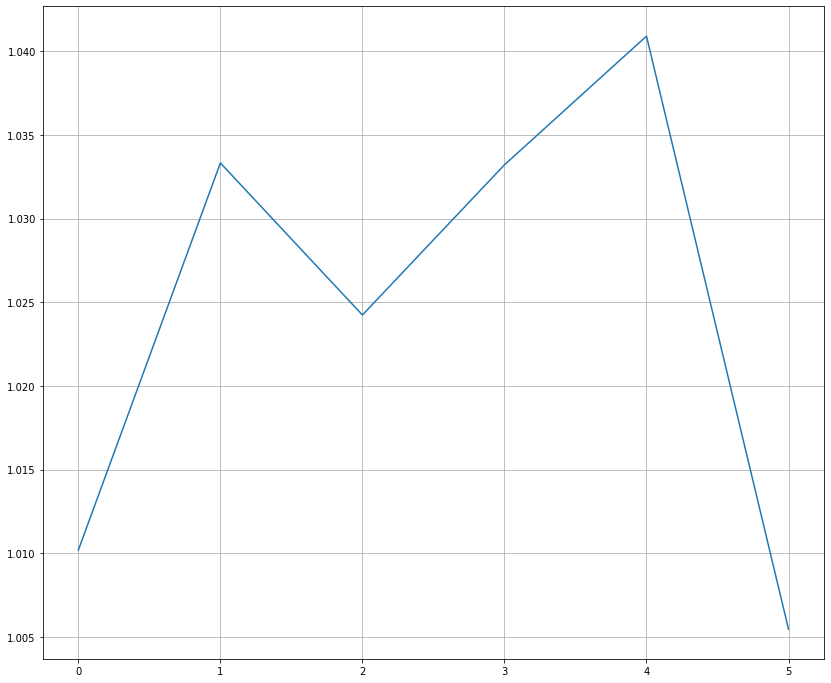

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 12))
plt.plot(train_loss_per_epoch)
plt.grid()

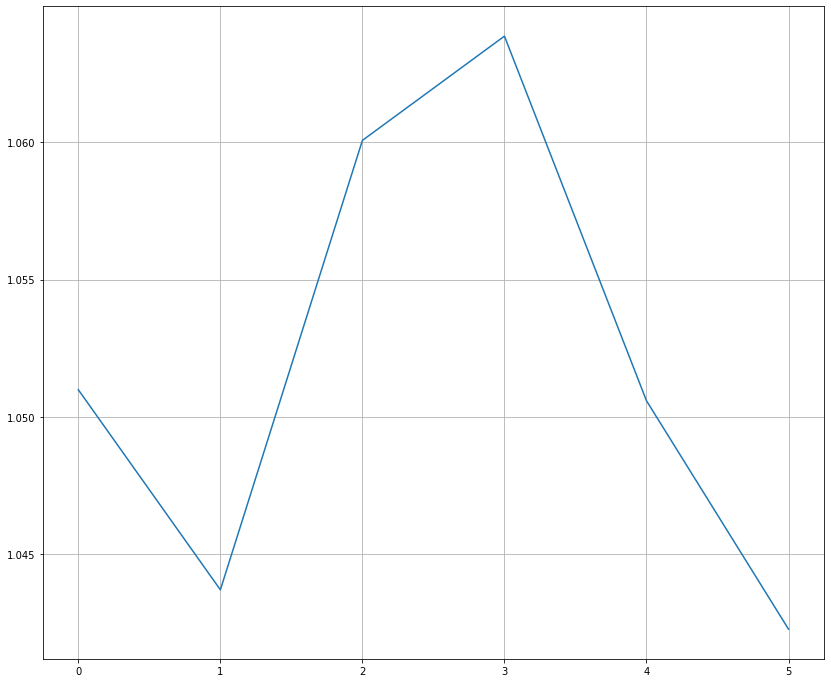

In [29]:
plt.figure(figsize=(14, 12))
plt.plot(test_loss_per_epoch)
plt.grid()

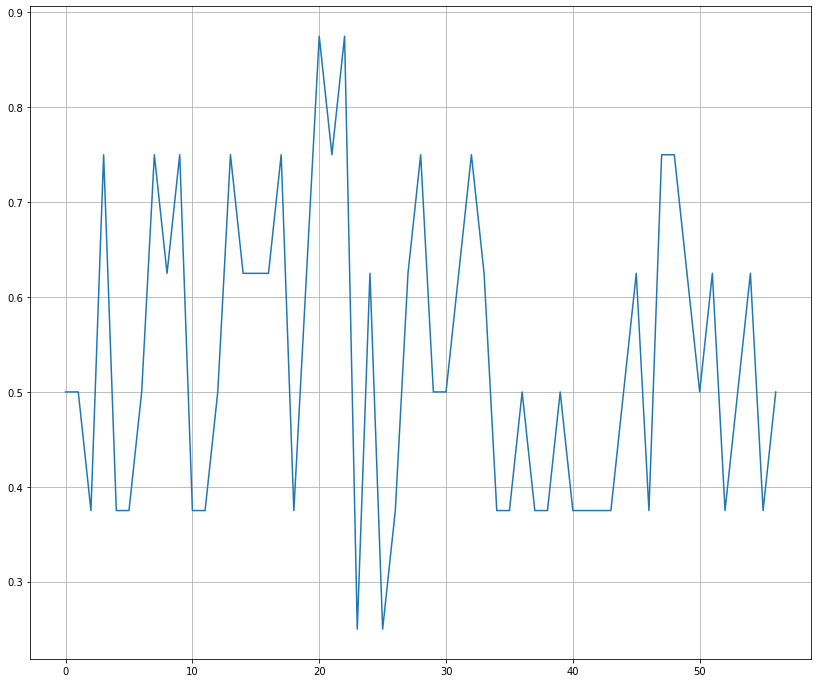

In [30]:
plt.figure(figsize=(14, 12))
plt.plot(train_f1s)
plt.grid()

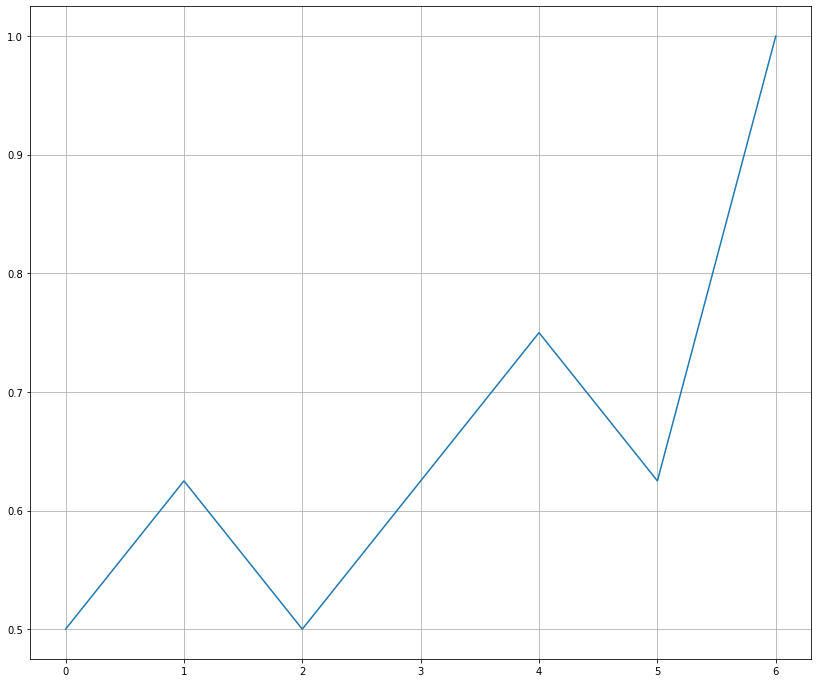

In [33]:
plt.figure(figsize=(14, 12))
plt.plot(test_f1s)
plt.grid()

In [34]:
print('Лучшая метрика на test:')
print('F1: ', max(test_f1s))

Лучшая метрика на test:
F1:  1.0


Я выдающимися знаниями особо никогда не блистал, поэтому для меня даже достаточно простая задача (если сравнивать с другими вариантами проектов) давалась непросто. Наверное, главная проблема, с которой я столкнулся — это подсчёт ф-меры на тесте. Довольно долго я получал нули после каждой эпохи. Причной этой проблемы, скорее всего, был неверный подсчёт: после внесения процесса подсчёта внутрь блока for element ib test_loader — удалось получить результат.
На последней эпохе предсказания класса делались со стопроцентной эффекимвностью: ф-мера на 6 эпохе стала равна единице.
В какой-то момент стало понятно, как получить качественный результат
Ф-мера на трейне вела себя довольно хаотично. Также, как видно на графиках, на 6 (последней) эпохе удаётся достичь минимальных лоссов.
Проект считаю успешно выполненым.